In [1]:
import pandas as pd
import json
from nltk import ngrams
#from datasketch.experimental.aio.lsh import AsyncMinHashLSH
#from datasketch import MinHash, MinHashLSH

In [2]:
articles = pd.read_json("data/assignment3_aricles.json", orient='records', encoding="utf-8")

In [3]:
import nltk
from nltk.util import ngrams
articles.head()

,Content,Title,article_id
0,Tikcro enters into research and license agreem...,Tikcro enters into research and license agreem...,0
1,A North Carolina woman is trying to warn other...,Facebook Friend Request Nearly Cost One North ...,1
2,LONDON--(BUSINESS WIRE)--\n\nAMLIN plc\n\nTOTA...,Amlin plc UK Regulatory Announcement: Total Vo...,2
3,Khaleda asks for security\n\n\n\nBNP Chairpers...,Khaleda asks for security,3
4,Liberian Health Clinics Reopen Slowly with Ren...,Liberian Health Clinics Reopen Slowly with Ren...,4


In [4]:
#You can use n-gram at word level for this task
#try with different n-gram values 
# You can use ngrams from nltk for this
def getNgrams(articles):
    n_grams = []
    #return articles with a field ngrams
    #articles['Content'] = articles['Content'].map(lambda x: x.lstrip("')(-?:/.,").rstrip('aAbBcC'))
    for content in articles['Content']:
        n = 2
        content = content.split(' ')
        content = [x.strip().replace('-', '') for x in content]
        content = [x.strip().replace('?', '') for x in content]
        content = [x.strip().replace(':', '') for x in content]
        content = [x.strip().replace('/', '') for x in content]
        content = [x.strip().replace('.', '') for x in content]
        content = [x.strip().replace(',', '') for x in content]
        content = [x.strip().replace('\\', '') for x in content]
        content = [x.strip().replace('(', '') for x in content]
        content = [x.strip().replace(')', '') for x in content]
        content = [x.strip().replace("'", '') for x in content]
        content = [x.strip().replace('"', '') for x in content]
        word_grams = []
        ngram = ngrams(content,n)
        word_grams.append(' '.join(str(i) for i in ngram))
        tmp = word_grams[0]
        n_grams.append(str(tmp))
    articles['temp'] = pd.Series(n_grams) #make new field 'ngrams'. Ngrams are the different sequences of length n in articles.
    n_grams = []
    #return articles with a field ngrams
    for title in articles['Title']:
        n = 2
        title = title.split(' ')
        title = [x.strip().replace('-', '') for x in title]
        title = [x.strip().replace('?', '') for x in title]
        title = [x.strip().replace(':', '') for x in title]
        title = [x.strip().replace('/', '') for x in title]
        title = [x.strip().replace('.', '') for x in title]
        title = [x.strip().replace(',', '') for x in title]
        title = [x.strip().replace('\\', '') for x in title]
        title = [x.strip().replace('(', '') for x in title]
        title = [x.strip().replace(')', '') for x in title]
        title = [x.strip().replace("'", '') for x in title]
        title = [x.strip().replace('"', '') for x in title]
        word_grams = []
        ngram = ngrams(title,n)
        word_grams.append(' '.join(str(i) for i in ngram))
        tmp2 = word_grams[0]
        n_grams.append(str(tmp2))
    articles['temp2'] = pd.Series(n_grams) 
getNgrams(articles)
articles['ngrams'] = articles['temp'] + articles['temp2']
articles = articles.drop(columns=['temp', 'temp2'])
articles.head()

,Content,Title,article_id,ngrams
0,Tikcro enters into research and license agreem...,Tikcro enters into research and license agreem...,0,"('Tikcro', 'enters') ('enters', 'into') ('into..."
1,A North Carolina woman is trying to warn other...,Facebook Friend Request Nearly Cost One North ...,1,"('A', 'North') ('North', 'Carolina') ('Carolin..."
2,LONDON--(BUSINESS WIRE)--\n\nAMLIN plc\n\nTOTA...,Amlin plc UK Regulatory Announcement: Total Vo...,2,"('LONDONBUSINESS', 'WIRE\n\nAMLIN') ('WIRE\n\n..."
3,Khaleda asks for security\n\n\n\nBNP Chairpers...,Khaleda asks for security,3,"('Khaleda', 'asks') ('asks', 'for') ('for', 's..."
4,Liberian Health Clinics Reopen Slowly with Ren...,Liberian Health Clinics Reopen Slowly with Ren...,4,"('Liberian', 'Health') ('Health', 'Clinics') (..."


## Convert n-grams into binary vector representation for each document. You can do some optimzations if the matrix is too big

In [5]:
articles['ngrams'] = articles['ngrams'].str.lower()
articles['ngrams'] = articles['ngrams'].str.replace("', '",' ').str.split("'\) \('")
for i,x in enumerate(articles['ngrams']):
    articles['ngrams'][i][0] = articles['ngrams'][i][0].replace("('",'')
    articles['ngrams'][i][len(articles['ngrams'][i])-1] = articles['ngrams'][i][len(articles['ngrams'][i])-1].replace("')",'')
print(articles.ngrams[0][0])

tikcro enters


In [6]:
#unique_ngrams = []
#for ngrams in articles['ngrams']:
#    unique_ngrams.append(list(set(ngrams)))

In [7]:
from scipy.sparse import csr_matrix

docs = articles.index
indptr = [0] 
indices = [] 
data = [] 
vocabulary = {} 
for d in docs:
    unique_ngrams = list(set(articles.ngrams[d]))
    for ngram in unique_ngrams:
        #if ngram in uniqueShingles
        index = vocabulary.setdefault(ngram, len(vocabulary)) 
        indices.append(index) 
        data.append(1) 
    indptr.append(len(indices))
binaryMatrix = csr_matrix((data, indices, indptr), dtype=int)
print(binaryMatrix.shape)


(48505, 3695498)


In [5]:
#binaryMatrixTransposed = binaryMatrix.transpose()
#print(binaryMatrixTransposed.shape)

['a']


## We need hash function that maps integers 0, 1, . . . , k − 1 to bucket numbers 0 through k − 1. It might be impossible to avoid collisions but as long as the collions are too many it won't matter much.

* The simplest would be using the builtin hash() function, it can be for example, hash(rownumber) % Numberofbuckets
* You can generate several of these hash functions by xoring a random integer (hash(rownumber)^randint) % Numberofbuckets
* It can also be a as simple as (rownumber * randint) % Numberofbuckets

In [9]:
import random
import numpy as np

hashValMatrix = np.empty((binaryMatrix.shape[1], 100))
def getHashFunctionValues(numrows, numhashfunctions):
    #return a matrix with hash values 
    numBuckets = numrows  
    rand_int = [random.randint(1, numrows) for i in range(0,numhashfunctions)]
    for i in range(0,numrows):
        hashValMatrix[i,:] = [(i^rand_int[j]) % numBuckets for j in range(numhashfunctions)] 
    return hashValMatrix

hashValMatrix=getHashFunctionValues(numrows=binaryMatrix.shape[1], numhashfunctions=100)

In [22]:
#print(hashValMatrix.shape)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
1
aa
bb
2
aa
bc
3
aa
bd
2
ab
bc
3
ab
bd
3
ac
bd


## Compute minhash following the faster algorithm from the lecture 

In [1]:
sign_matrix = np.memmap('LSH.sign_matrix', dtype=np.float64, mode='w+',
              shape=(hashValMatrix.shape[1],binaryMatrix.shape[0]))
#sign_matrix = np.memmap('LSH.sign_matrix', dtype=np.float64, mode='r+',
#              shape=(hashValMatrix.shape[1],binaryMatrixTransposed.shape[0]))
print(sign_matrix.shape)

def getMinHashSignatureMatrix(binary_matrix, hash_val_matrix):
#return minhash signature matrix 
    for row in range(binary_matrix.shape[0]):
        #Column indices for row:
        #print(range(binary_matrix.shape[0]))
        #print(row)
        ind = binary_matrix.indices[binary_matrix.indptr[row]:binary_matrix.indptr[row+1]]
        #indices of nonzero elements in row 
        for hash_col in range(hash_val_matrix.shape[1]): 
            #add column values for row:
            sign_matrix[hash_col,row] = min(hash_val_matrix[:,hash_col][ind]) 
    return sign_matrix
#columns = signatures
sign_matrix = getMinHashSignatureMatrix(binaryMatrix, hashValMatrix)
print(sign_matrix.shape)

NameError: name 'np' is not defined

## Hash signature bands into buckets. Find a way to combine all the signature values in a band and hash them into a number of buckets ususally very high.
* Easiest way is to add all the signature values in the bucket and use a similar hash function like before

In [24]:
#BRUK NP HVIS FOR TREGT
#SUBMISSION FILE COLUMNS?

#1. divide signature matrix into bands of rows (divide into b parts of r rows).
#2. for each band, map each column to a integer/bucket number. can use same hash function for all bands. buckets should be 
#unique for each band.
#3. candidate pair: hashed to same bucket using atleast one band
import itertools
from collections import OrderedDict
def getLSH(signature_matrix, num_bands, num_buckets):
    signature_matrix_transposed = np.transpose(signature_matrix) #transpose before splitting on columns
    bands = np.hsplit(signature_matrix_transposed, num_bands) #b = 20, r = 5
    all_buckets = [None]*num_bands
    buckets = [None]*num_buckets
    tempSum = [None]*signature_matrix.shape[1]
    for i,band in enumerate(bands):
        print(i)
        band = np.transpose(band)
        for article in range(band.shape[1]):
            tempSum[article] = sum(band[:,article]) % num_buckets #can use same hash function for all bands -> no need for randint
        tempSumIndexes = [test for test in itertools.combinations(range(len(tempSum)), 2)]
        for a, b in enumerate(itertools.combinations(tempSum, 2)):
            if (b[0]==b[1]) && (tempSumIndexes[a][0] not in buckets[a]) && (tempSumIndexes[a][0]!=a):
                buckets[a].append(tempSumIndexes[a][0])
            if (b[0]==b[1]) && (tempSumIndexes[a][1] not in buckets[a] && (tempSumIndexes[a][1]!=a)):
                buckets[a].append(tempSumIndexes[a][1])
        all_buckets.append(buckets)
    final_buckets = []
    final_buckets = zip(*all_buckets)
    #remove duplicates in buckets:
    for i,articles in enumerate(final_buckets):
        final_buckets[i]=list(OrderedDict.fromkeys(final_buckets))
    return final_buckets
nearest_neighbours = getLSH(sign_matrix,20,48505)



#for j in tempSum:
        #    buckets[j]==[]
        #    for idx,k in enumerate(tempSum):
        #        if j==k and idx not in buckets[j]:
        #            buckets[j].append(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Tune parameters to make sure the threshold is appropriate.
## plot the probability of two similar items falling in same bucked for different threshold values


[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[0.0, 0.00019998100113904904, 0.0063805813047682625, 0.04749425912497118, 0.1860495521491441, 0.4700507153168765, 0.8019024538382217, 0.9747805441880405, 0.9996439421094793, 0.9999999824090121, 1.0]


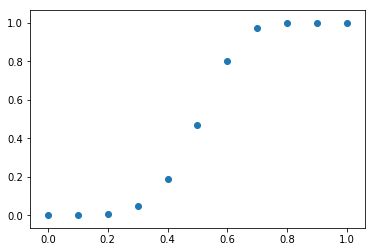

In [18]:
from matplotlib import pyplot as plt
num_bands = 20
r = 5
x_axis = [float(x/10) for x in range(0,11)]
print(x_axis)
y_axis = [1-(1-t**r)**num_bands for t in x_axis]
print(y_axis)
plt.scatter(x_axis,y_axis)
plt.show()

## Choose the best parameters and get nearest neighbors of each articles

## Write the results to submissions.csv file and get the score

In [ ]:
#write article ids, nearest neighbours (documents in same buckets)
[article_ids = i for i in range(sign_matrix.shape[1])]

sub = pd.DataFrame()
    sub['Id'] = article_ids #article IDs
    sub['NearestNeighbours'] = nearest_neighbours
    sub.to_csv('submission.csv',index=False)
#DUE 18.03